In [1]:
import numpy as np
from jax import jit, vmap, debug
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import os,sys,re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from itertools import cycle, islice
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'image.cmap':'jet'}
plt.rcParams.update(params)
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
from tqdm import tqdm
from EmuLP import Analysis, Template, Extinction, Galaxy, Filter

2023-10-23 11:11:40.485389: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
summary_props = pd.read_pickle('FORS2_spectra_classif_properties.pkl')
df_sl_spec = pd.read_pickle('FORS2-SL_spectra_for_templates.pkl')

In [3]:
df_sl_spec.columns

Index(['Wavelength', 'SPEC_2_HZ4_BC_EBV0_Z0', 'SPEC_2_HZ4_BC_EBV0.112_Z0',
       'SPEC_2_HZ4_BC_EBV0.112_Z0.346', 'SPEC_3_HZ4_BC_EBV0_Z0',
       'SPEC_3_HZ4_BC_EBV0.081_Z0', 'SPEC_3_HZ4_BC_EBV0.081_Z0.687',
       'SPEC_9_HZ4_BC_EBV0_Z0', 'SPEC_9_HZ4_BC_EBV0.024_Z0',
       'SPEC_9_HZ4_BC_EBV0.024_Z0.293',
       ...
       'SPEC_735_HZ4_BC_EBV0.067_Z0.362', 'SPEC_736_HZ4_BC_EBV0_Z0',
       'SPEC_736_HZ4_BC_EBV0.191_Z0', 'SPEC_736_HZ4_BC_EBV0.191_Z0.558',
       'SPEC_737_HZ4_BC_EBV0_Z0', 'SPEC_737_HZ4_BC_EBV0.000_Z0',
       'SPEC_737_HZ4_BC_EBV0.000_Z0.520', 'SPEC_738_HZ4_BC_EBV0_Z0',
       'SPEC_738_HZ4_BC_EBV0.002_Z0', 'SPEC_738_HZ4_BC_EBV0.002_Z0.560'],
      dtype='object', length=1651)

In [4]:
summary_props

,FORS2-SL Id,RA[deg],DEC[deg],Redshift,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),...,M(hsc_rHSC)_z0_e0,M(hsc_iHSC)_z0_e0,M(hsc_zHSC)_z0_e0,M(hsc_yHSC)_z0_e0,E(B-V) (Calzetti),D4000n,NUVK,Type,Tag,Lines
0,2,13.52997,-28.44776,0.34555,25.821886,25.921856,25.040974,23.704586,23.013096,22.630671,...,9.887968,9.419348,9.189159,8.939938,1.124278e-01,0.731663,6.377514,E/S0,"SPEC2 , z=0.35, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
1,3,13.52552,-28.42080,0.68660,27.474937,27.486893,26.909842,25.811043,24.925348,24.702564,...,10.384878,10.199041,10.113859,10.029570,8.140638e-02,0.823350,5.338274,E/S0,"SPEC3 , z=0.69, lines=[OII],H9,K,H,H{beta},[OI...","b'[OII],H9,K,H,H{beta},[OIII],H8 ..."
2,9,13.50219,-28.40641,0.29266,25.663216,25.914091,24.416805,23.163275,22.570648,22.297443,...,10.226454,9.809847,9.619812,9.432680,2.434813e-02,0.643971,6.761829,E/S0,"SPEC9 , z=0.29, lines=H9,H8,K,H","b'H9,H8,K,H ..."
3,13,13.49261,-28.38272,0.68870,26.572910,26.594807,26.396280,26.103289,25.844692,25.799042,...,11.081982,10.937572,10.771805,10.602051,2.297509e-01,1.034968,3.822172,Sbc,"SPEC13 , z=0.69, lines=[OII],H{epsilon},H{delt...","b'[OII],H{epsilon},H{delta},H{beta} ..."
4,19,13.60758,-28.43452,0.48395,26.472153,26.558479,25.837456,24.469170,23.801319,23.434643,...,9.596317,9.217987,9.018663,8.792568,1.717975e-01,0.806435,6.399498,E/S0,"SPEC19 , z=0.48, lines=H10,H9,H8,K,H,H{delta}","b'H10,H9,H8,K,H,H{delta} ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.23012,21.773840,21.832668,21.096130,20.369307,19.936716,19.658907,...,7.687561,7.413023,7.260187,7.087929,1.629334e-01,0.856027,4.841396,E/S0,"SPEC734 , z=0.23, lines=[OII],H9,K,H,H{alpha},NII","b'[OII],H9,K,H,H{alpha},NII ..."
546,735,13.69958,-28.23161,0.36169,23.926516,24.541979,22.297907,20.770287,20.160078,19.871609,...,7.132578,6.811829,6.653036,6.454988,6.709273e-02,0.634273,8.569615,E/S0,"SPEC735 , z=0.36, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
547,736,13.66431,-28.22849,0.55777,25.969648,25.999710,25.712921,25.045811,24.664101,24.482536,...,10.285772,10.155405,10.092361,10.018002,1.912414e-01,0.957919,4.205803,Sbc,"SPEC736 , z=0.56, lines=[OII],H9,H{beta},[OIII]","b'[OII],H9,H{beta},[OIII] ..."
548,737,13.62722,-28.22692,0.52001,25.798443,25.905743,25.058142,23.921850,23.384155,23.156130,...,9.813402,9.603807,9.512367,9.436058,4.692699e-22,0.785689,4.916520,E/S0,"SPEC737 , z=0.52, lines=[OII],K,H","b'[OII],K,H ..."


In [5]:
summary_props['Type'] = [ "E-S0" if typ=='E/S0' else typ for typ in summary_props['Type'].values ]
summary_props

,FORS2-SL Id,RA[deg],DEC[deg],Redshift,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),...,M(hsc_rHSC)_z0_e0,M(hsc_iHSC)_z0_e0,M(hsc_zHSC)_z0_e0,M(hsc_yHSC)_z0_e0,E(B-V) (Calzetti),D4000n,NUVK,Type,Tag,Lines
0,2,13.52997,-28.44776,0.34555,25.821886,25.921856,25.040974,23.704586,23.013096,22.630671,...,9.887968,9.419348,9.189159,8.939938,1.124278e-01,0.731663,6.377514,E-S0,"SPEC2 , z=0.35, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
1,3,13.52552,-28.42080,0.68660,27.474937,27.486893,26.909842,25.811043,24.925348,24.702564,...,10.384878,10.199041,10.113859,10.029570,8.140638e-02,0.823350,5.338274,E-S0,"SPEC3 , z=0.69, lines=[OII],H9,K,H,H{beta},[OI...","b'[OII],H9,K,H,H{beta},[OIII],H8 ..."
2,9,13.50219,-28.40641,0.29266,25.663216,25.914091,24.416805,23.163275,22.570648,22.297443,...,10.226454,9.809847,9.619812,9.432680,2.434813e-02,0.643971,6.761829,E-S0,"SPEC9 , z=0.29, lines=H9,H8,K,H","b'H9,H8,K,H ..."
3,13,13.49261,-28.38272,0.68870,26.572910,26.594807,26.396280,26.103289,25.844692,25.799042,...,11.081982,10.937572,10.771805,10.602051,2.297509e-01,1.034968,3.822172,Sbc,"SPEC13 , z=0.69, lines=[OII],H{epsilon},H{delt...","b'[OII],H{epsilon},H{delta},H{beta} ..."
4,19,13.60758,-28.43452,0.48395,26.472153,26.558479,25.837456,24.469170,23.801319,23.434643,...,9.596317,9.217987,9.018663,8.792568,1.717975e-01,0.806435,6.399498,E-S0,"SPEC19 , z=0.48, lines=H10,H9,H8,K,H,H{delta}","b'H10,H9,H8,K,H,H{delta} ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.23012,21.773840,21.832668,21.096130,20.369307,19.936716,19.658907,...,7.687561,7.413023,7.260187,7.087929,1.629334e-01,0.856027,4.841396,E-S0,"SPEC734 , z=0.23, lines=[OII],H9,K,H,H{alpha},NII","b'[OII],H9,K,H,H{alpha},NII ..."
546,735,13.69958,-28.23161,0.36169,23.926516,24.541979,22.297907,20.770287,20.160078,19.871609,...,7.132578,6.811829,6.653036,6.454988,6.709273e-02,0.634273,8.569615,E-S0,"SPEC735 , z=0.36, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
547,736,13.66431,-28.22849,0.55777,25.969648,25.999710,25.712921,25.045811,24.664101,24.482536,...,10.285772,10.155405,10.092361,10.018002,1.912414e-01,0.957919,4.205803,Sbc,"SPEC736 , z=0.56, lines=[OII],H9,H{beta},[OIII]","b'[OII],H9,H{beta},[OIII] ..."
548,737,13.62722,-28.22692,0.52001,25.798443,25.905743,25.058142,23.921850,23.384155,23.156130,...,9.813402,9.603807,9.512367,9.436058,4.692699e-22,0.785689,4.916520,E-S0,"SPEC737 , z=0.52, lines=[OII],K,H","b'[OII],K,H ..."


<AxesSubplot:xlabel='E(B-V) (Calzetti)', ylabel='Count'>

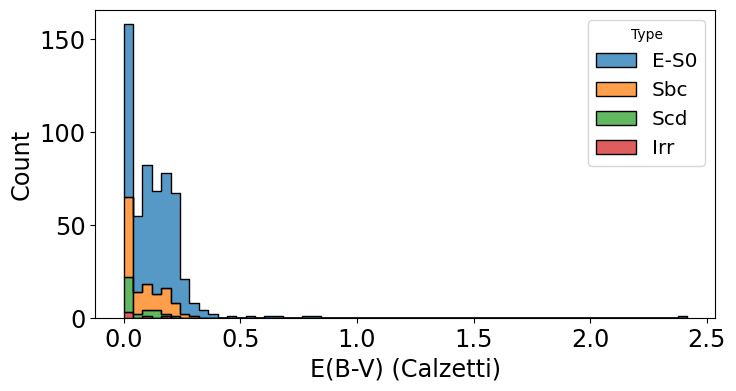

In [6]:
sns.histplot(data=summary_props, x='E(B-V) (Calzetti)', hue='Type', stat='count', multiple='stack', element='step')

In [7]:
counts, edges = np.histogram(summary_props['E(B-V) (Calzetti)'].values, bins='auto')
edges

array([4.69269901e-22, 4.02647612e-02, 8.05295224e-02, 1.20794284e-01,
       1.61059045e-01, 2.01323806e-01, 2.41588567e-01, 2.81853328e-01,
       3.22118089e-01, 3.62382851e-01, 4.02647612e-01, 4.42912373e-01,
       4.83177134e-01, 5.23441895e-01, 5.63706657e-01, 6.03971418e-01,
       6.44236179e-01, 6.84500940e-01, 7.24765701e-01, 7.65030462e-01,
       8.05295224e-01, 8.45559985e-01, 8.85824746e-01, 9.26089507e-01,
       9.66354268e-01, 1.00661903e+00, 1.04688379e+00, 1.08714855e+00,
       1.12741331e+00, 1.16767807e+00, 1.20794284e+00, 1.24820760e+00,
       1.28847236e+00, 1.32873712e+00, 1.36900188e+00, 1.40926664e+00,
       1.44953140e+00, 1.48979616e+00, 1.53006092e+00, 1.57032569e+00,
       1.61059045e+00, 1.65085521e+00, 1.69111997e+00, 1.73138473e+00,
       1.77164949e+00, 1.81191425e+00, 1.85217901e+00, 1.89244378e+00,
       1.93270854e+00, 1.97297330e+00, 2.01323806e+00, 2.05350282e+00,
       2.09376758e+00, 2.13403234e+00, 2.17429710e+00, 2.21456187e+00,
      

In [8]:
np.histogram(summary_props[summary_props['Type']=='E/S0']['E(B-V) (Calzetti)'].values, bins=edges)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([4.69269901e-22, 4.02647612e-02, 8.05295224e-02, 1.20794284e-01,
        1.61059045e-01, 2.01323806e-01, 2.41588567e-01, 2.81853328e-01,
        3.22118089e-01, 3.62382851e-01, 4.02647612e-01, 4.42912373e-01,
        4.83177134e-01, 5.23441895e-01, 5.63706657e-01, 6.03971418e-01,
        6.44236179e-01, 6.84500940e-01, 7.24765701e-01, 7.65030462e-01,
        8.05295224e-01, 8.45559985e-01, 8.85824746e-01, 9.26089507e-01,
        9.66354268e-01, 1.00661903e+00, 1.04688379e+00, 1.08714855e+00,
        1.12741331e+00, 1.16767807e+00, 1.20794284e+00, 1.24820760e+00,
        1.28847236e+00, 1.32873712e+00, 1.36900188e+00, 1.40926664e+00,
        1.44953140e+00, 1.48979616e+00, 1.53006092e+00, 1.57032569e+00,
        1.61059045e+00, 1.65085521e+00, 1.69111997e+00, 1.73138473e+00,
  

In [9]:
_sel = np.logical_and(np.logical_and(summary_props['E(B-V) (Calzetti)']>=edges[0],\
                                     summary_props['E(B-V) (Calzetti)']<edges[1]),\
                      summary_props['Type']=='Irr')

In [10]:
summary_props[_sel]['FORS2-SL Id'].values
nums = summary_props[_sel]['FORS2-SL Id'].values
ebvs = summary_props[_sel]['E(B-V) (Calzetti)'].values
wls = df_sl_spec['Wavelength'].values
_nsel = np.logical_and(wls>1000., wls<10000.)
specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
specs = np.column_stack(specs_to_stack)
norms = np.trapz(specs[_nsel], x=wls[_nsel], axis=0)
specsN_to_stack = tuple(specs[:,j]/norms[j] for j in range(len(norms)))
normed_specs = jnp.column_stack(specsN_to_stack)

(0.0, 10000.0)

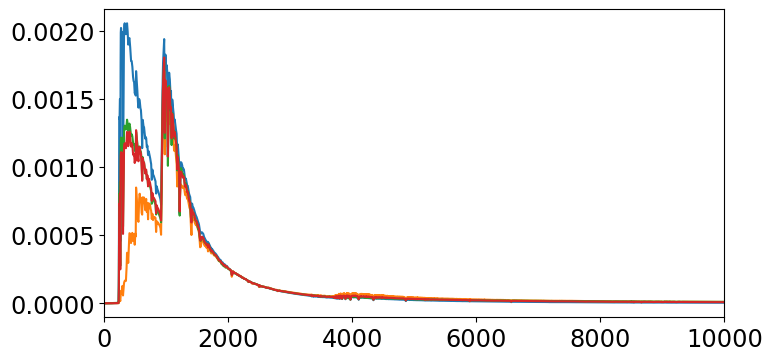

In [11]:
for j in range(normed_specs.shape[1]):
    plt.plot(wls, normed_specs[:,j])
avg_spec = np.mean(normed_specs, axis=1)
plt.plot(wls, avg_spec)
plt.xlim(0., 10000.)

In [12]:
def avg_spec(gal_type, ebv_low, ebv_high):
    _sel = np.logical_and(np.logical_and(summary_props['E(B-V) (Calzetti)']>ebv_low,\
                                         summary_props['E(B-V) (Calzetti)']<=ebv_high),\
                          summary_props['Type']==gal_type)
    if np.any(_sel):
        print(f"Type: {gal_type}, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V) (Calzetti)'].values
        wls = df_sl_spec['Wavelength'].values
        _nsel = np.logical_and(wls>1000., wls<10000.)
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
        specs = np.column_stack(specs_to_stack)
        norms = np.trapz(specs[_nsel], x=wls[_nsel], axis=0)
        specsN_to_stack = tuple(specs[:,j]/norms[j] for j in range(len(norms)))
        normed_specs = jnp.column_stack(specsN_to_stack)
        avg_spec = np.mean(normed_specs, axis=1)
        dev_spec = np.std(normed_specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

In [13]:
df_dusty_templates = pd.DataFrame()
df_dusty_templates['Wavelength'] = df_sl_spec['Wavelength'].values
for galtyp in np.unique(summary_props['Type'].values):
    for e_inf, e_sup in zip(edges[:-1], edges[1:]):
        avg_typ_ebv, sig_typ_ebv = avg_spec(galtyp, e_inf, e_sup)
        if avg_typ_ebv is not None:
            df_dusty_templates[f'AVG_{galtyp}_EBV{0.5*(e_inf+e_sup):.3f}'] = avg_typ_ebv
        
df_dusty_templates

Type: E-S0, avg E(B-V): 0.020 - 92 spectra
Type: E-S0, avg E(B-V): 0.060 - 41 spectra
Type: E-S0, avg E(B-V): 0.101 - 64 spectra
Type: E-S0, avg E(B-V): 0.141 - 55 spectra
Type: E-S0, avg E(B-V): 0.181 - 62 spectra
Type: E-S0, avg E(B-V): 0.221 - 59 spectra
Type: E-S0, avg E(B-V): 0.262 - 19 spectra
Type: E-S0, avg E(B-V): 0.302 - 7 spectra
Type: E-S0, avg E(B-V): 0.342 - 4 spectra
Type: E-S0, avg E(B-V): 0.383 - 2 spectra
Type: E-S0, avg E(B-V): 0.463 - 1 spectra
Type: E-S0, avg E(B-V): 0.544 - 1 spectra
Type: E-S0, avg E(B-V): 0.624 - 1 spectra
Type: E-S0, avg E(B-V): 0.664 - 1 spectra
Type: E-S0, avg E(B-V): 0.785 - 1 spectra
Type: E-S0, avg E(B-V): 0.825 - 1 spectra
Type: E-S0, avg E(B-V): 2.396 - 1 spectra
Type: Irr, avg E(B-V): 0.020 - 3 spectra
Type: Irr, avg E(B-V): 0.101 - 1 spectra
Type: Irr, avg E(B-V): 0.181 - 1 spectra
Type: Sbc, avg E(B-V): 0.020 - 43 spectra
Type: Sbc, avg E(B-V): 0.060 - 12 spectra
Type: Sbc, avg E(B-V): 0.101 - 14 spectra
Type: Sbc, avg E(B-V): 0.141 -

,Wavelength,AVG_E-S0_EBV0.020,AVG_E-S0_EBV0.060,AVG_E-S0_EBV0.101,AVG_E-S0_EBV0.141,AVG_E-S0_EBV0.181,AVG_E-S0_EBV0.221,AVG_E-S0_EBV0.262,AVG_E-S0_EBV0.302,AVG_E-S0_EBV0.342,...,AVG_Sbc_EBV0.181,AVG_Sbc_EBV0.221,AVG_Sbc_EBV0.262,AVG_Sbc_EBV0.302,AVG_Scd_EBV0.020,AVG_Scd_EBV0.060,AVG_Scd_EBV0.101,AVG_Scd_EBV0.141,AVG_Scd_EBV0.181,AVG_Scd_EBV0.221
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996.0,0.000117,0.000132,0.000135,0.000137,0.000155,0.000179,0.000211,0.000275,0.000232,...,0.000066,0.000061,0.00007,0.000105,0.000024,0.000028,0.000035,0.000027,0.000034,0.000039
24996,24997.0,0.000117,0.000132,0.000135,0.000137,0.000155,0.000179,0.000211,0.000275,0.000232,...,0.000066,0.000061,0.00007,0.000105,0.000024,0.000028,0.000035,0.000027,0.000034,0.000039
24997,24998.0,0.000117,0.000132,0.000135,0.000137,0.000155,0.000179,0.000211,0.000275,0.000232,...,0.000066,0.000061,0.00007,0.000105,0.000024,0.000028,0.000035,0.000027,0.000034,0.000039
24998,24999.0,0.000117,0.000132,0.000135,0.000137,0.000155,0.000179,0.000211,0.000275,0.000232,...,0.000066,0.000061,0.00007,0.000105,0.000024,0.000028,0.000035,0.000027,0.000034,0.000039


<AxesSubplot:xlabel='Wavelength'>

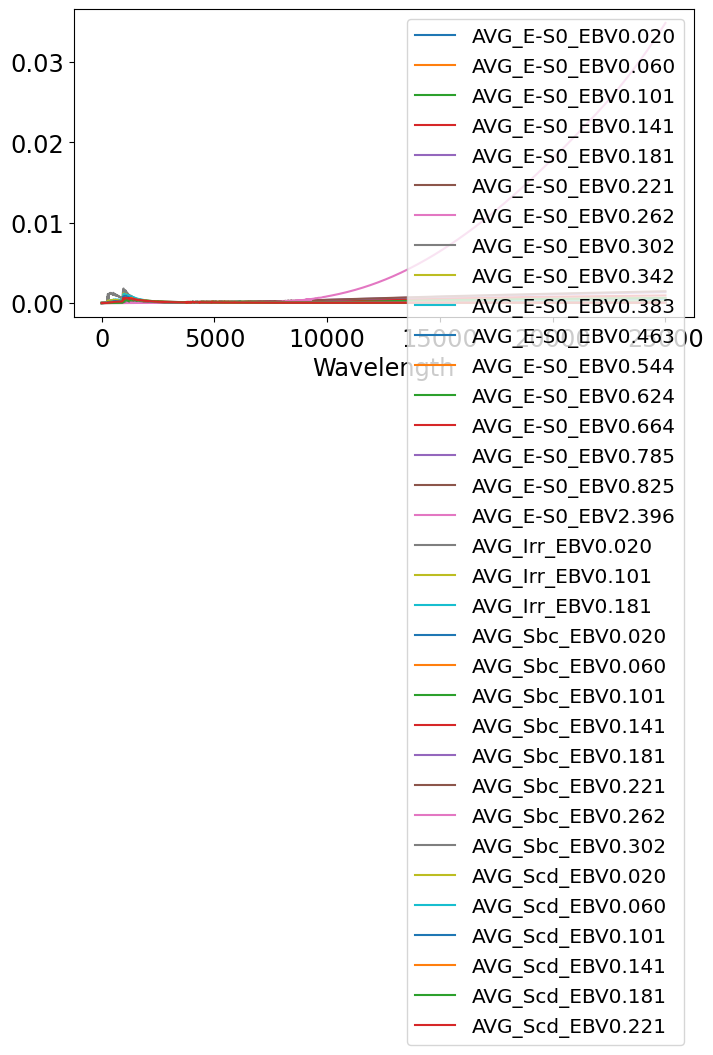

In [14]:
df_dusty_templates.plot(x='Wavelength')

In [15]:
if os.getenv('LEPHAREDIR') is not None:
    LEPHAREDIR = os.getenv('LEPHAREDIR')
else:
    LEPHAREDIR = os.path.abspath(os.path.join(os.getcwd(), "LEPHARE"))
    os.environ['LEPHAREDIR'] = LEPHAREDIR
print(os.environ['LEPHAREDIR'])

lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    LEPHAREWORK = os.environ['LEPHAREWORK']
else:
    LEPHAREWORK = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = LEPHAREWORK
print(os.environ['LEPHAREWORK'])

/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD/LEPHARE
/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD/lephare_cosmos


In [16]:
_gal_seds = 'FORS2_DustySelect_batch1'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', _gal_seds)
if not os.path.isdir(sed_dir) : os.makedirs(sed_dir)
list_file_name = f'SED_FORS2_DustySelect_SL_v1'

In [17]:
if True:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their type and E(B-V) value\n')
    for _col in df_dusty_templates.columns[1:]:
        _arr = np.column_stack((df_dusty_templates['Wavelength'], df_dusty_templates[_col]))
        np.savetxt(os.path.join(sed_dir,f'{_col}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
            _l.write(_gal_seds+f'/{_col}.sed\n')

In [18]:
sorted(os.listdir(sed_dir))

['AVG_E-S0_EBV0.020.sed',
 'AVG_E-S0_EBV0.060.sed',
 'AVG_E-S0_EBV0.101.sed',
 'AVG_E-S0_EBV0.141.sed',
 'AVG_E-S0_EBV0.181.sed',
 'AVG_E-S0_EBV0.221.sed',
 'AVG_E-S0_EBV0.262.sed',
 'AVG_E-S0_EBV0.302.sed',
 'AVG_E-S0_EBV0.342.sed',
 'AVG_E-S0_EBV0.383.sed',
 'AVG_E-S0_EBV0.463.sed',
 'AVG_E-S0_EBV0.544.sed',
 'AVG_E-S0_EBV0.624.sed',
 'AVG_E-S0_EBV0.664.sed',
 'AVG_E-S0_EBV0.785.sed',
 'AVG_E-S0_EBV0.825.sed',
 'AVG_E-S0_EBV2.396.sed',
 'AVG_Irr_EBV0.020.sed',
 'AVG_Irr_EBV0.101.sed',
 'AVG_Irr_EBV0.181.sed',
 'AVG_Sbc_EBV0.020.sed',
 'AVG_Sbc_EBV0.060.sed',
 'AVG_Sbc_EBV0.101.sed',
 'AVG_Sbc_EBV0.141.sed',
 'AVG_Sbc_EBV0.181.sed',
 'AVG_Sbc_EBV0.221.sed',
 'AVG_Sbc_EBV0.262.sed',
 'AVG_Sbc_EBV0.302.sed',
 'AVG_Scd_EBV0.020.sed',
 'AVG_Scd_EBV0.060.sed',
 'AVG_Scd_EBV0.101.sed',
 'AVG_Scd_EBV0.141.sed',
 'AVG_Scd_EBV0.181.sed',
 'AVG_Scd_EBV0.221.sed']